In [55]:
import polars as pl
import functools

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.optimize import fsolve, curve_fit, minimize, least_squares
from IPython.display import clear_output
from matplotlib import ticker
from tqdm.notebook import tqdm
from joblib import Parallel, delayed

In [56]:
def get_noise_label(hybrid_mixing_shift):
    if hybrid_mixing_shift == 0.0:
        return "balanced"
    if hybrid_mixing_shift <= -1e2:
        return "masked"
    if hybrid_mixing_shift >= 1e2:
        return "uniform"
    if hybrid_mixing_shift < 0:
        return "low-uniform"
    if hybrid_mixing_shift > 0:
        return "high-uniform"

colors = {
    -1000.0: (58, 76, 192),
    -2.0: (141, 175, 253),
    0.0: (122, 220, 121),
    2.0: (243, 152, 121),
    1000.0: (179, 3, 38),
}

In [57]:
df_ = pl.read_csv("../../losses.csv")

df_ = df_.filter(pl.col("batch_size") < 1024)
df_ = df_.filter((pl.col("steps") <= 100000) & (pl.col("steps") > 5000)).sort("non_emb_params")
df_grouped = df_.group_by("hybrid_mixing_shift", "non_emb_params", "target_loss").agg(pl.all().sort_by("tokens").first())

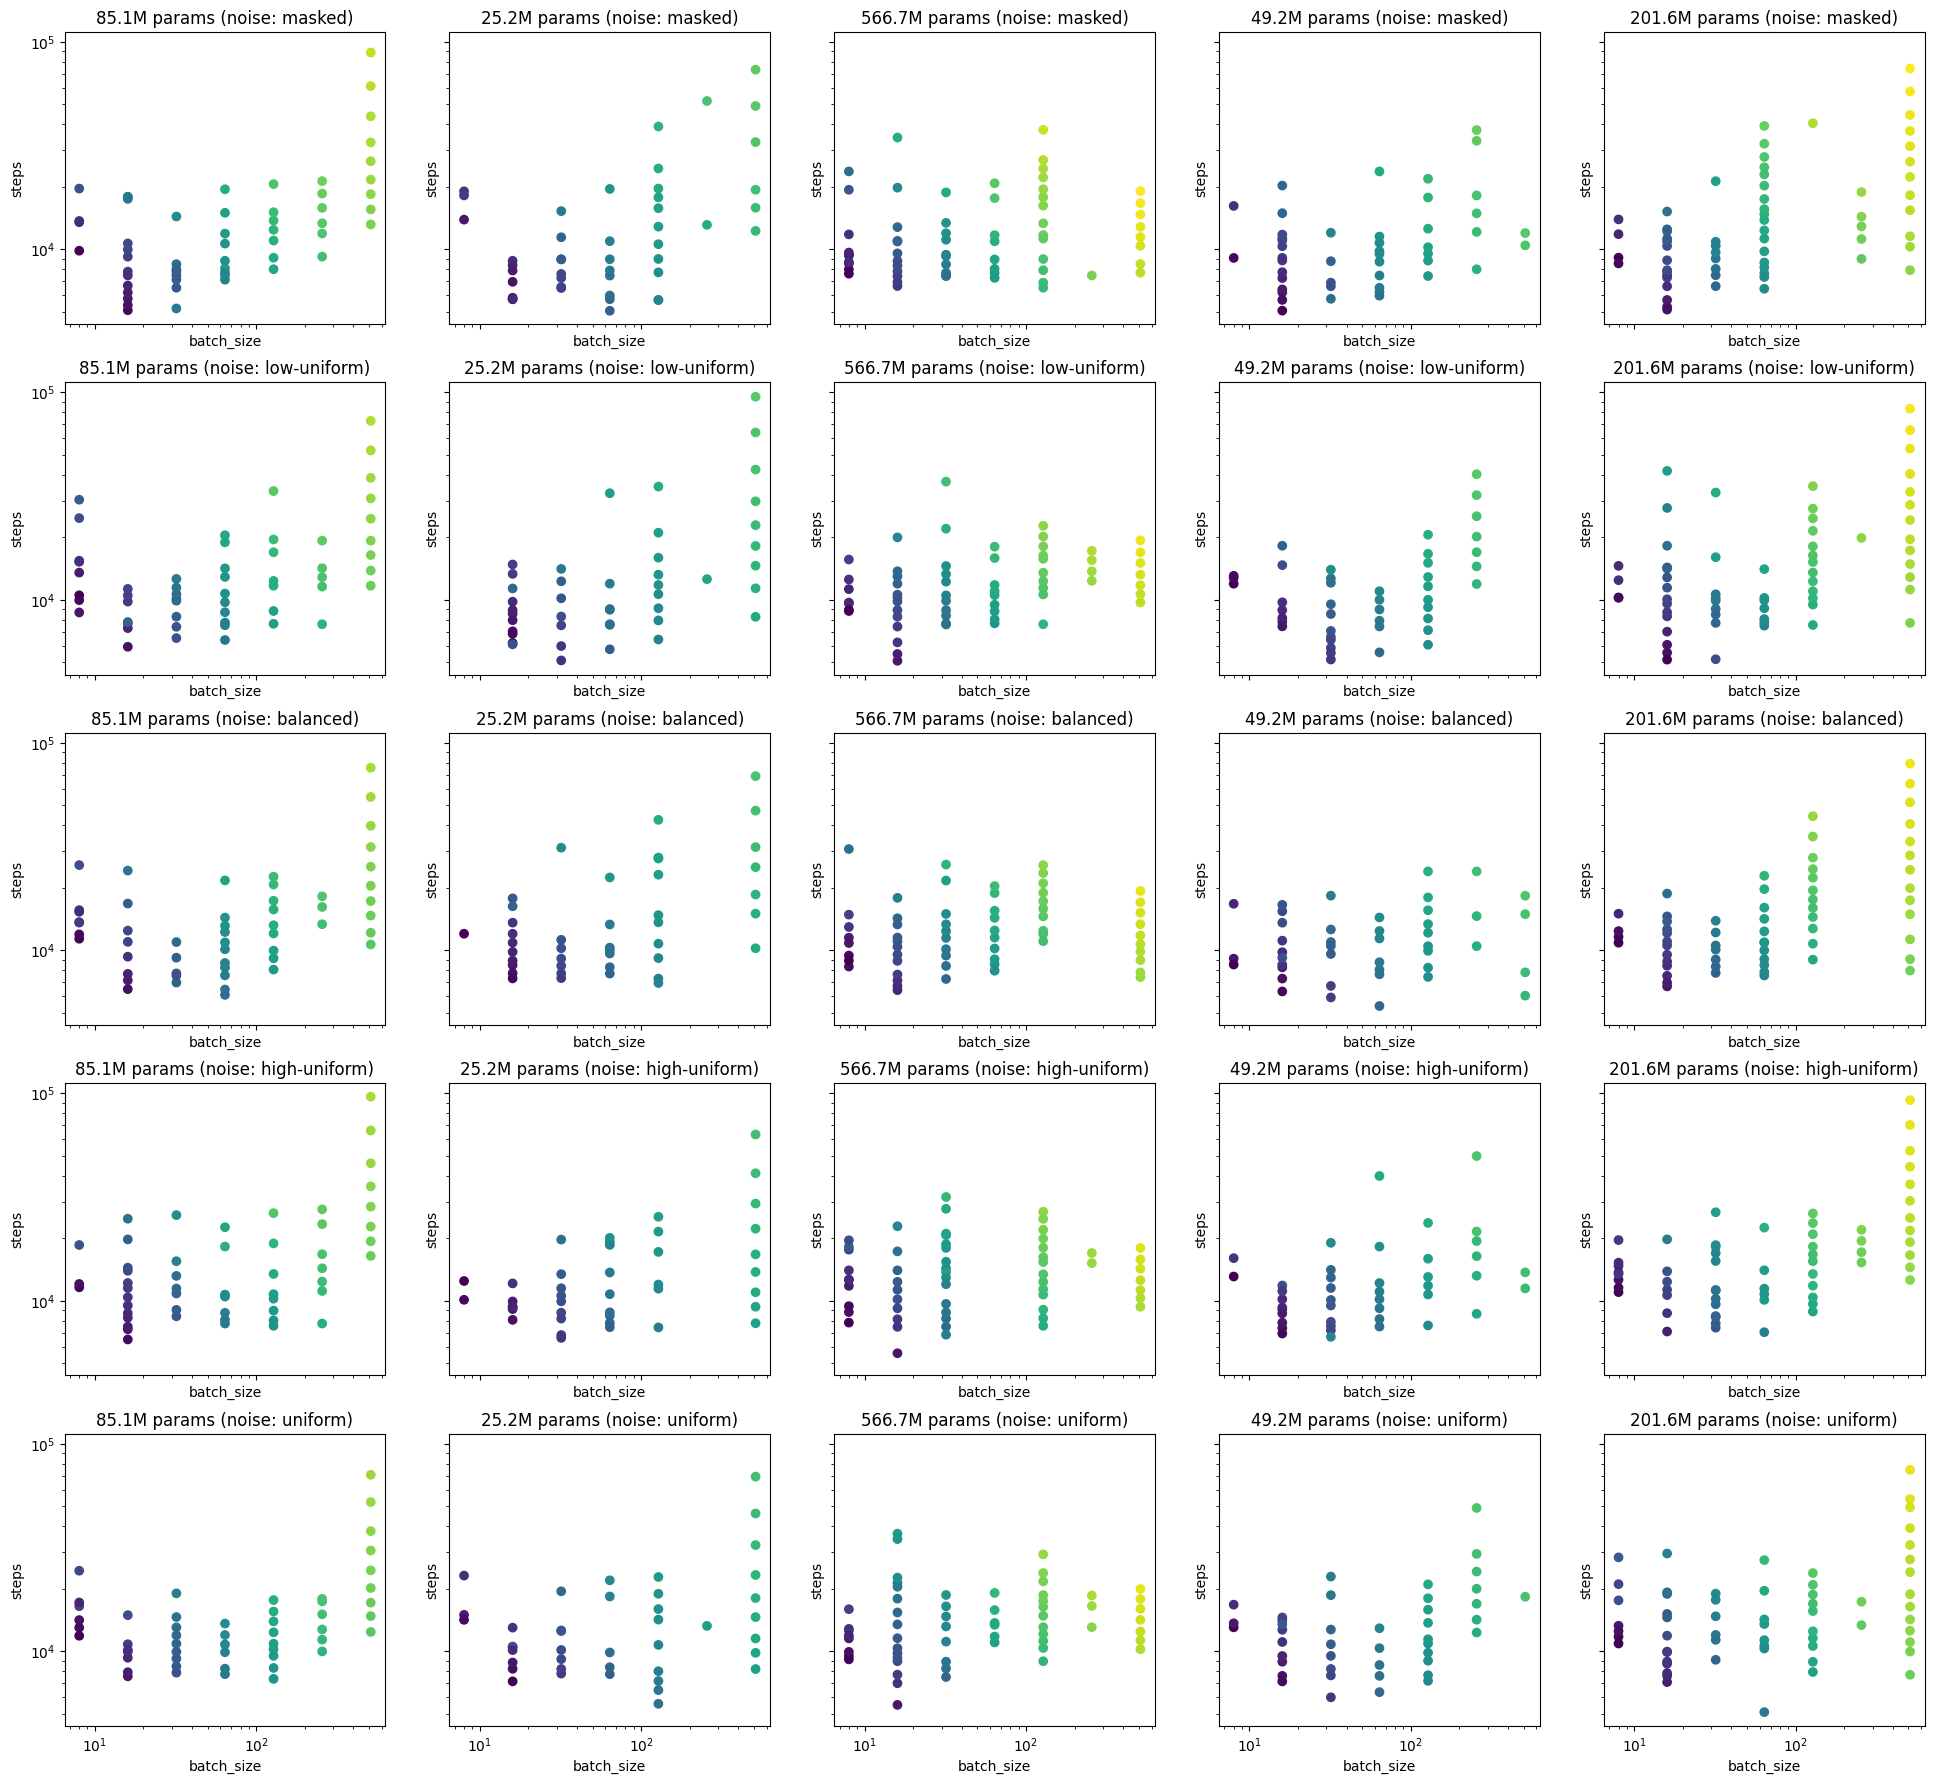

In [58]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x.clip(-10, 10)))

fig, axs = plt.subplots(5, len(df_["non_emb_params"].unique()), figsize=(24, 22), sharex=True, sharey=True)

vmin, vmax = df_["target_loss"].min(), df_["target_loss"].max()

for i, ((params, ), dfi) in enumerate(df_grouped.group_by("non_emb_params")):
    for j, ((hybrid_mixing_shift, ), dfj) in enumerate(dfi.sort("hybrid_mixing_shift").group_by("hybrid_mixing_shift")):
        ax = axs[j, i]
        # ax.scatter(dfj["batch_size"], dfj["steps"], c=sigmoid(dfj["hybrid_mixing_shift"]))
        ax.scatter(dfj["batch_size"], dfj["steps"], c=dfj["target_loss"], cmap="viridis_r", vmin=vmin, vmax=vmax)

        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_xlabel("batch_size")
        ax.set_ylabel("steps")
        ax.set_title(f"{params/1e6:.1f}M params (noise: {get_noise_label(hybrid_mixing_shift)})")

In [144]:
scaling_laws = {}
fit_in_logspace = True
n_bootstraps = 10000
n_jobs = -1

def hypothesis1(P, D, a, alpha, b, beta, E):
    return E + a * P**-alpha + b * D**-beta

def bootstrap_fit(dfi, base_resid, p1_0, seed):
    bootstrap_df = dfi.sample(n=len(dfi), with_replacement=True, seed=seed)
    dfi_grouped = bootstrap_df.group_by("non_emb_params", "target_loss").agg(pl.all().sort_by("tokens").first())
    bootstrap_P1 = dfi_grouped["non_emb_params"].to_numpy()
    bootstrap_D1 = dfi_grouped["tokens"].to_numpy()
    bootstrap_L1 = dfi_grouped["target_loss"].to_numpy()

    bootstrap_resid1 = functools.partial(base_resid, functools.partial(hypothesis1, bootstrap_P1, bootstrap_D1), bootstrap_L1)
    bootstrap_sol1 = least_squares(bootstrap_resid1, p1_0, bounds=(1e-8, np.inf), loss="huber")

    return bootstrap_sol1.x



for i, ((hybrid_mixing_shift, ), dfi) in enumerate(df_.sort("hybrid_mixing_shift").group_by("hybrid_mixing_shift")):

    dfi_grouped = dfi.group_by("non_emb_params", "target_loss").agg(pl.all().sort_by("tokens").first())
    P1, D1, L1 = dfi_grouped["non_emb_params"].to_numpy(), dfi_grouped["tokens"].to_numpy(), dfi_grouped["target_loss"].to_numpy()

    transform = lambda x: x
    if fit_in_logspace:
        transform = np.log

    def base_resid(f, y, p):
        return transform(f(*p)) - transform(y)

    resid1 = functools.partial(base_resid, functools.partial(hypothesis1, P1, D1), L1)
    
    #p1_0 = (1.0,) * 5
    p1_0 = (20.0, 0.23, 300.0, 0.29, 1.0)

    sol1 = least_squares(resid1, p1_0, bounds=(1e-8, np.inf), loss="huber")

    # chunk to get a nice tqdm progress (joblib finishes batches at once)
    chunk_size = 64
    seeds = list(range(n_bootstraps))
    bootstrap_params = []
    for start in tqdm(range(0, n_bootstraps, chunk_size), desc=f"Bootstrapping shift={hybrid_mixing_shift}"):
        chunk = seeds[start:start + chunk_size]
        bootstrap_params.extend(
            Parallel(n_jobs=n_jobs, backend="loky", prefer="processes")(
                delayed(bootstrap_fit)(dfi, base_resid, sol1.x, seed) for seed in chunk
            )
        )
        
    bootstrap_params = np.array(bootstrap_params)
    m = bootstrap_params.mean(axis=0)
    std = bootstrap_params.std(axis=0)

    print(f"Mean {get_noise_label(hybrid_mixing_shift):10s}: a={m[0]:.3g},\talpha={m[1]:.3g},\tb={m[2]:.3g},\tbeta={m[3]:.3g},\tE={m[4]:.3g}")
    print(f"Std  {get_noise_label(hybrid_mixing_shift):10s}: a={std[0]:.3g},\talpha={std[1]:.3g},\tb={std[2]:.3g},\tbeta={std[3]:.3g},\tE={std[4]:.3g}")
    print(f"Fit  {get_noise_label(hybrid_mixing_shift):10s}: a={sol1.x[0]:.3g},\talpha={sol1.x[1]:.3g},\tb={sol1.x[2]:.3g},\tbeta={sol1.x[3]:.3g},\tE={sol1.x[4]:.3g}")

    scaling_laws[hybrid_mixing_shift] = {
        "func": hypothesis1,
        "resid": resid1,
        "args": (P1, D1),
        "y": L1,
        "p": sol1.x,
        "p_bootstrap": bootstrap_params
    }

Bootstrapping shift=-1000:   0%|          | 0/157 [00:00<?, ?it/s]

Mean masked    : a=41.2,	alpha=0.243,	b=664,	beta=0.315,	E=2.21
Std  masked    : a=15.5,	alpha=0.0248,	b=56.9,	beta=0.00478,	E=0.0503
Fit  masked    : a=44.7,	alpha=0.253,	b=645,	beta=0.314,	E=2.23


Bootstrapping shift=-2:   0%|          | 0/157 [00:00<?, ?it/s]

Mean low-uniform: a=48.9,	alpha=0.25,	b=489,	beta=0.296,	E=2.2
Std  low-uniform: a=23.8,	alpha=0.0311,	b=61.1,	beta=0.0069,	E=0.0602
Fit  low-uniform: a=50,	alpha=0.26,	b=466,	beta=0.295,	E=2.22


Bootstrapping shift=0:   0%|          | 0/157 [00:00<?, ?it/s]

Mean balanced  : a=36.5,	alpha=0.234,	b=399,	beta=0.284,	E=2.16
Std  balanced  : a=11.8,	alpha=0.022,	b=45.1,	beta=0.00622,	E=0.0447
Fit  balanced  : a=32.4,	alpha=0.23,	b=352,	beta=0.278,	E=2.14


Bootstrapping shift=2:   0%|          | 0/157 [00:00<?, ?it/s]

Mean high-uniform: a=20.4,	alpha=0.188,	b=417,	beta=0.287,	E=2.04
Std  high-uniform: a=6.56,	alpha=0.0235,	b=45.2,	beta=0.00606,	E=0.0819
Fit  high-uniform: a=17.3,	alpha=0.18,	b=381,	beta=0.283,	E=2.01


Bootstrapping shift=1000:   0%|          | 0/157 [00:00<?, ?it/s]

Mean uniform   : a=13.4,	alpha=0.153,	b=393,	beta=0.283,	E=1.87
Std  uniform   : a=3.35,	alpha=0.0198,	b=32.1,	beta=0.00466,	E=0.104
Fit  uniform   : a=12.1,	alpha=0.148,	b=356,	beta=0.279,	E=1.84


In [145]:
coefficient_fits = [s["p_bootstrap"] for s in scaling_laws.values()]

In [146]:
# quick sanity check of coefficients
import numpy as np
from scipy.stats import permutation_test

def stat(x, y):
    return np.mean(x) - np.mean(y)

res = permutation_test((coefficient_fits[-1][:,1], coefficient_fits[0][:,1]), stat,
                       vectorized=False, permutation_type='independent', n_resamples=1_000, alternative='less')
print(res.pvalue)  # tests H1: mean(a) < mean(b)

0.000999000999000999


In [147]:
from scipy.stats import ttest_ind
# H1: mean(a) < mean(b)
t = ttest_ind(coefficient_fits[-1][:,1], coefficient_fits[0][:,1], equal_var=False, alternative='less')
print(t.statistic, t.pvalue)

-281.4567895793496 0.0


/var/folders/b_/6gztjjy15vq9brgmv41d128h0000gn/T/ipykernel_20883/3618296399.py:65: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


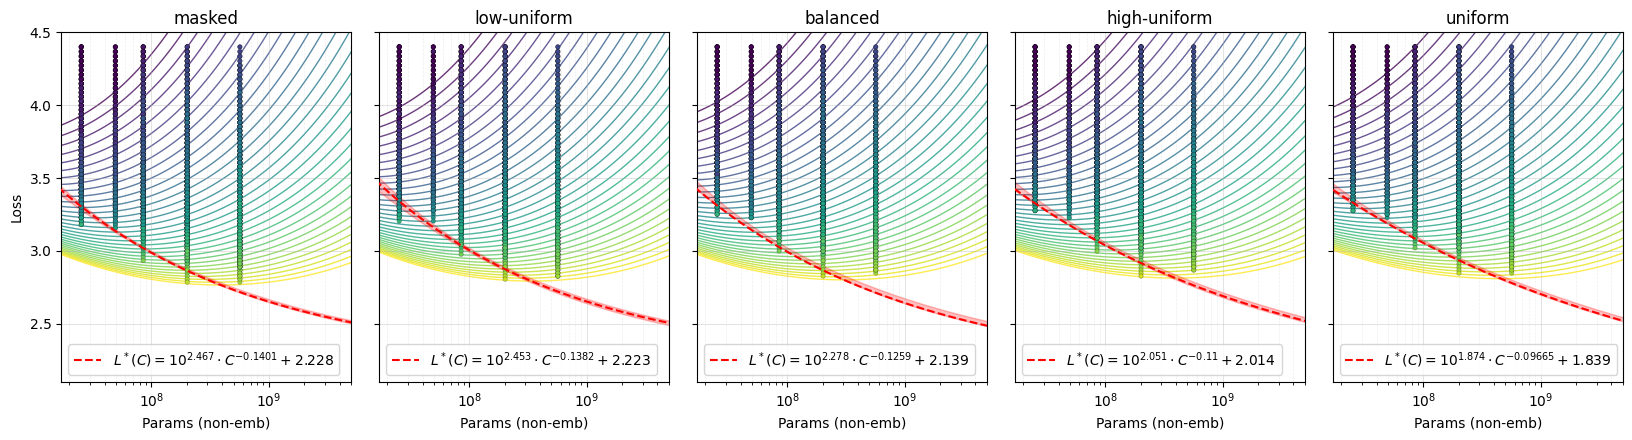

In [148]:

fig, axs = plt.subplots(1, 5, figsize=(17, 4.5), sharex=True, sharey="row")

flop_targets = np.logspace(17, np.log10(2e20), 32)

def color(x):
    cmap = plt.get_cmap("viridis")
    norm = plt.Normalize(vmin=np.log(flop_targets).min(), vmax=np.log(flop_targets).max())
    return cmap(norm(np.log(x)))


def eval_bootstrap_params(bootstrap_array, params, percentile_alpha=15.85):
    a, alpha, b, beta, E = bootstrap_array[:,:,None]
    L_star_P = E + a*(alpha + beta)/beta * params[None,:]**(-alpha)
    lower = np.percentile(L_star_P, percentile_alpha, axis=0)
    upper = np.percentile(L_star_P, 100 - percentile_alpha, axis=0)
    return lower, upper



for i, (hybrid_mixing_shift, scaling_law) in enumerate(scaling_laws.items()):
    ax = axs[i]
    for flops in flop_targets:
        params = np.logspace(7, 10, 100)
        tokens = flops / (6 * params)

        loss = scaling_law["func"](params, tokens, *scaling_law["p"])
        ax.plot(params, loss, color=color(flops), alpha=0.8, zorder=1, linewidth=1.0)

        batch_size = np.logspace(3, 7, 100)
        steps = flops / (6 * params[:, None] * batch_size[None, :])

    dfi = df_.filter(pl.col("hybrid_mixing_shift") == hybrid_mixing_shift)
    xs = dfi["non_emb_params"]
    ys = dfi["target_loss"]
    c = dfi["tokens"] * xs * 6
    ax.scatter(xs, ys, c=np.log(c), cmap="viridis", vmin=np.log(flop_targets.min()), vmax=np.log(flop_targets.max()), edgecolor=(0, 0, 0, 0.3), linewidth=0.5, s=10, zorder=2)

    a, alpha, b, beta, E = scaling_law["p"]
    C_star_a = (alpha + beta) * (a/beta)**(beta/(alpha + beta)) * (b/alpha)**(alpha/(alpha + beta))
    C_star_alpha = (-(alpha*beta)/(alpha + beta))
    L_star_P = E + a*(alpha + beta)/beta * params**(-alpha)
    ax.plot(params, L_star_P, linestyle="--", color="red", label="$L^*(C) = 10^{{{:.4g}}} \\cdot C^{{{:.4g}}} + {:.3f}$".format(np.log10(C_star_a), C_star_alpha, E), zorder=3)

    lower, upper = eval_bootstrap_params(scaling_law["p_bootstrap"].T, params)
    ax.fill_between(params, lower, upper, alpha=0.25, color="red")


    ax.set_title(f"{get_noise_label(hybrid_mixing_shift)}")
    ax.set_xscale("log")
    # ax.set_yscale("log")
    ax.set_ylim(None, 4.5)
    ax.set_xlim(1.7e7, 5e9)
    ax.legend()


    ax.grid(True, which="major", linestyle="-", linewidth=0.5, alpha=0.5, zorder=0)
    ax.grid(True, which="minor", linestyle="--", linewidth=0.5, alpha=0.2, zorder=0)

for ax in axs.flatten():
    ax.set_xlabel("Params (non-emb)")

axs[0].set_ylabel("Loss")

fig.tight_layout(w_pad=-2.0)
fig.show()
#fig.savefig("plots/scaling_laws.pdf", dpi=300, bbox_inches="tight")

masked: $L^*(C) = 10^{2.467} \cdot C^{-0.1401} + 2.228$
low-uniform: $L^*(C) = 10^{2.453} \cdot C^{-0.1382} + 2.223$
balanced: $L^*(C) = 10^{2.278} \cdot C^{-0.1259} + 2.139$
high-uniform: $L^*(C) = 10^{2.051} \cdot C^{-0.11} + 2.014$
uniform: $L^*(C) = 10^{1.874} \cdot C^{-0.09665} + 1.839$


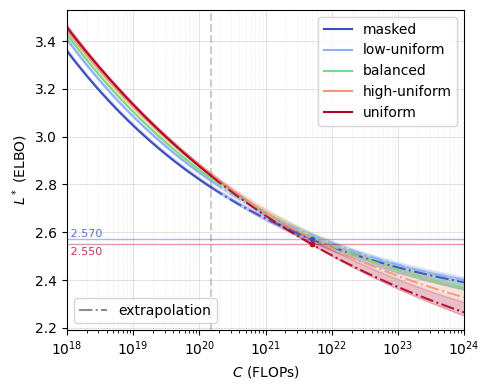

In [149]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))

intra_flops = np.logspace(18, np.log10(1.5e20), 50)
extra_flops = np.logspace(np.log10(1.5e20), 24, 50)
flops = np.logspace(18, 24, 100)

idx = np.argmin(np.abs(flops - 1.5e20))

ax.axvline(x=1.5e20, color="gray", linestyle="--", alpha=0.4)
ax.plot([], [], linestyle="-.", color="gray", alpha=0.9, label="extrapolation")

def eval_bootstrap_flops(bootstrap_array, flops, percentile_alpha=15.85):
    a, alpha, b, beta, E = bootstrap_array[:,:,None]
    C_star_a = (alpha + beta) * (a/beta)**(beta/(alpha + beta)) * (b/alpha)**(alpha/(alpha + beta))
    C_star_alpha = (-(alpha*beta)/(alpha + beta))

    L_star_C = E + C_star_a * (flops[None,:]/6)**C_star_alpha
    lower = np.percentile(L_star_C, percentile_alpha, axis=0)
    upper = np.percentile(L_star_C, 100 - percentile_alpha, axis=0)
    return lower, upper

for i, (hybrid_mixing_shift, scaling_law) in enumerate(scaling_laws.items()):
    color = colors[hybrid_mixing_shift]

    a, alpha, b, beta, E = scaling_law["p"]
    C_star_a = (alpha + beta) * (a/beta)**(beta/(alpha + beta)) * (b/alpha)**(alpha/(alpha + beta))
    C_star_alpha = (-(alpha*beta)/(alpha + beta))

    lower_intra, upper_intra = eval_bootstrap_flops(scaling_law["p_bootstrap"].T, intra_flops)
    L_star_C_intra = E + C_star_a * (intra_flops/6)**C_star_alpha
    lower_extra, upper_extra = eval_bootstrap_flops(scaling_law["p_bootstrap"].T, extra_flops)
    L_star_C_extra = E + C_star_a * (extra_flops/6)**C_star_alpha


    if hybrid_mixing_shift == -1000.0:
        C = 5e21
        L = E + C_star_a * (C/6)**C_star_alpha
        ax.plot([C], [L], ".", color=np.array(color)/255.0, zorder=10)
        ax.axhline(y=L, color=np.array(color)/255.0, linestyle="-", alpha=0.4, linewidth=1.0)
        ax.text(1e18, L, f" {L:.3f}", fontsize=8, va="bottom", ha="left", color=np.array(color)/255.0, alpha=0.8)

    
    if hybrid_mixing_shift == 1000.0:
        C = 5e21
        L = E + C_star_a * (C/6)**C_star_alpha
        ax.plot([C], [L], ".", color=np.array(color)/255.0, zorder=10)
        ax.axhline(y=L, color=np.array(color)/255.0, linestyle="-", alpha=0.4, linewidth=1.0)
        ax.text(1e18, L*0.996, f" {L:.3f}", fontsize=8, va="top", ha="left", color=np.array(color)/255.0, alpha=0.8)

    label = get_noise_label(hybrid_mixing_shift)
    ax.plot(intra_flops, L_star_C_intra, linestyle="-", color=np.array(color)/255.0, label=label)
    ax.fill_between(intra_flops, lower_intra, upper_intra, alpha=0.25, color=np.array(color)/255.0)
    ax.plot(extra_flops, L_star_C_extra, linestyle="-.", color=np.array(color)/255.0, alpha=0.9)
    ax.fill_between(extra_flops, lower_extra, upper_extra, alpha=0.25, color=np.array(color)/255.0)

    print(get_noise_label(hybrid_mixing_shift) + ": $L^*(C) = 10^{{{:.4g}}} \\cdot C^{{{:.4g}}} + {:.3f}$".format(np.log10(C_star_a), C_star_alpha, E))


handles, labels = ax.get_legend_handles_labels()
trend_mask = [lbl.startswith("extrapolation") for lbl in labels]
trend_handles = [h for h, m in zip(handles, trend_mask) if m]
trend_labels = [l for l, m in zip(labels, trend_mask) if m]
main_handles = [h for h, m in zip(handles, trend_mask) if not m]
main_labels = [l for l, m in zip(labels, trend_mask) if not m]

leg_main = ax.legend(main_handles, main_labels, loc="upper right")
ax.add_artist(leg_main)
ax.legend(trend_handles, trend_labels, loc="lower left")

ax.set_xscale("log")
# ax.set_yscale("log")
# ax.legend()

ax.grid(True, which="major", linestyle="-", linewidth=0.5, alpha=0.5)
ax.grid(True, which="minor", linestyle="--", linewidth=0.5, alpha=0.2)

ax.set_xlim(1e18, 1e24)

ax.set_xlabel("$C$ (FLOPs)")
ax.set_ylabel("$L^*$ (ELBO)")
fig.tight_layout()
#fig.savefig("plots/compute_optimal_frontier.pdf", bbox_inches="tight")

masked: P^* \propto C^{0.553}, D^* \propto C^{0.447}
low-uniform: P^* \propto C^{0.531}, D^* \propto C^{0.469}
balanced: P^* \propto C^{0.547}, D^* \propto C^{0.453}
high-uniform: P^* \propto C^{0.611}, D^* \propto C^{0.389}
uniform: P^* \propto C^{0.653}, D^* \propto C^{0.347}


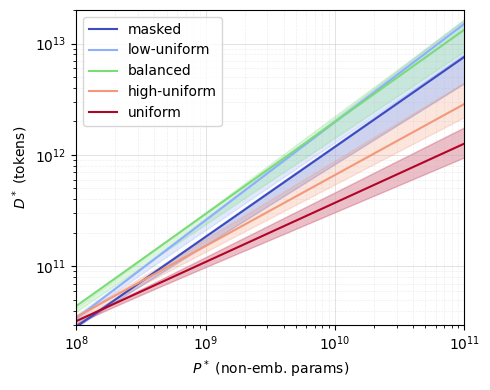

In [150]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))

def bootstrap_flops_on_params(bootstrap_array, flops, percentile_alpha=15.85):
    a, alpha, b, beta, E = bootstrap_array[:,:,None]
    P_star_a, P_star_alpha = ((a*alpha)/(b*beta))**(1/(alpha + beta)), (beta/(alpha + beta))
    D_star_a, D_star_alpha = ((b*beta)/(a*alpha))**(1/(alpha + beta)), (alpha/(alpha + beta))

    params = P_star_a * (flops[None,:]/6)**P_star_alpha
    tokens = D_star_a * (flops[None,:]/6)**D_star_alpha

    # # bin and hist
    # params = params.ravel()
    # tokens = tokens.ravel()
    # n_bins = 100
    # bins = np.logspace(8, 11, n_bins + 1)
    #
    # # Assign bins (idx in [0, n_bins-1]); drop out-of-range and non-finite
    # idx = np.digitize(params, bins) - 1
    # valid = (idx >= 0) & (idx < n_bins) & np.isfinite(params) & np.isfinite(tokens)
    # x, y, idx = params[valid], tokens[valid], idx[valid]
    #
    # # Prepare outputs
    # counts = np.bincount(idx, minlength=n_bins)
    # q = np.array([percentile_alpha, 100 - percentile_alpha])
    # out = np.full((n_bins, q.size), np.nan)
    #
    # # Compute percentiles per bin
    # for i in range(n_bins):
    #     if counts[i] < 1:
    #         continue
    #     yi = y[idx == i]
    #     if yi.size == 0:
    #         continue
    #     else:
    #         out[i] = np.percentile(yi, q)
    #
    # # Bin centers (geometric is handy for log-scaled x)
    # bin_center = np.sqrt(bins[:-1] * bins[1:])
    #
    # return bin_center, out[:,0], out[:,1]

    med_p = np.percentile(params, 50.0, axis=0)
    lo_d, hi_d = np.percentile(tokens, [percentile_alpha, 100.0 - percentile_alpha], axis=0)
    return med_p, lo_d, hi_d



for hybrid_mixing_shift, scaling_law in scaling_laws.items():
    color = colors[hybrid_mixing_shift]

    a, alpha, b, beta, E = scaling_law["p"]
    P_star_a, P_star_alpha = ((a*alpha)/(b*beta))**(1/(alpha + beta)), (beta/(alpha + beta))
    D_star_a, D_star_alpha = ((b*beta)/(a*alpha))**(1/(alpha + beta)), (alpha/(alpha + beta))

    flops = np.logspace(18, 26, 100)
    params = P_star_a * (flops/6)**P_star_alpha
    tokens = D_star_a * (flops/6)**D_star_alpha

    # label = f"$P^* \\propto C^{{{P_star_alpha:.3g}}}$\n$D^* \\propto C^{{{D_star_alpha:.3g}}}$"
    label = get_noise_label(hybrid_mixing_shift)
    ax.plot(params, tokens, color=np.array(color)/255.0, label=label)

    # do the bootstrop
    med_p, lo_d, hi_d = bootstrap_flops_on_params(scaling_law["p_bootstrap"].T, flops)
    ax.fill_between(med_p, lo_d, hi_d, alpha=0.25, color=np.array(color)/255.0)

    print(f"{get_noise_label(hybrid_mixing_shift)}: P^* \\propto C^{{{P_star_alpha:.3g}}}, D^* \\propto C^{{{D_star_alpha:.3g}}}")



ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(1e8, 1e11)
ax.set_ylim(3e10, 2e13)

ax.grid(True, which="major", linestyle="-", linewidth=0.5, alpha=0.5)
ax.grid(True, which="minor", linestyle="--", linewidth=0.5, alpha=0.2)

ax.set_xlabel("$P^*$ (non-emb. params)")
ax.set_ylabel("$D^*$ (tokens)")
# ax.legend(loc="center left", bbox_to_anchor=(1.0, 0.5), labelspacing=1.0)
ax.legend()
fig.tight_layout()
#fig.savefig("plots/opt_params_tokens.pdf", bbox_inches="tight")

masked: P^* \propto C^{0.553}, D^* \propto C^{0.447}
low-uniform: P^* \propto C^{0.531}, D^* \propto C^{0.469}
balanced: P^* \propto C^{0.547}, D^* \propto C^{0.453}
high-uniform: P^* \propto C^{0.611}, D^* \propto C^{0.389}
uniform: P^* \propto C^{0.653}, D^* \propto C^{0.347}


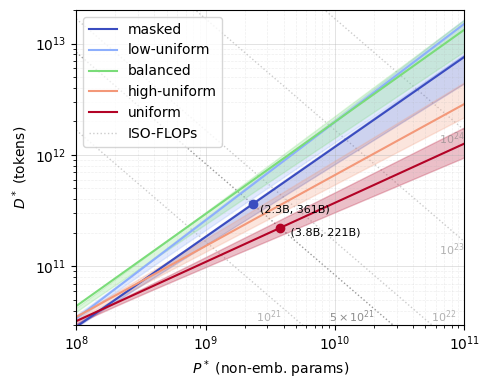

In [152]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))

trained_flops = 5e21

for hybrid_mixing_shift, scaling_law in scaling_laws.items():
    color = colors[hybrid_mixing_shift]


    a, alpha, b, beta, E = scaling_law["p"]
    P_star_a, P_star_alpha = ((a*alpha)/(b*beta))**(1/(alpha + beta)), (beta/(alpha + beta))
    D_star_a, D_star_alpha = ((b*beta)/(a*alpha))**(1/(alpha + beta)), (alpha/(alpha + beta))

    flops = np.logspace(18, 26, 100)
    params = P_star_a * (flops/6)**P_star_alpha
    tokens = D_star_a * (flops/6)**D_star_alpha

    # label = f"$P^* \\propto C^{{{P_star_alpha:.3g}}}$\n$D^* \\propto C^{{{D_star_alpha:.3g}}}$"
    label = get_noise_label(hybrid_mixing_shift)
    ax.plot(params, tokens, color=np.array(color)/255.0, label=label)

    # do the bootstrop
    med_p, lo_d, hi_d = bootstrap_flops_on_params(scaling_law["p_bootstrap"].T, flops)
    ax.fill_between(med_p, lo_d, hi_d, alpha=0.25, color=np.array(color)/255.0)
    
    if hybrid_mixing_shift == -1000.0:
        P = P_star_a * (trained_flops/6)**P_star_alpha
        D = D_star_a * (trained_flops/6)**D_star_alpha
        ax.plot([P], [D], "o", color=np.array(color)/255.0)
        ax.text(P, D, f"  ({P/1e9:.1f}B, {D/1e9:.0f}B)", fontsize=8, va="top", ha="left")

    
    if hybrid_mixing_shift == 1000.0:
        P = P_star_a * (trained_flops/6)**P_star_alpha
        D = D_star_a * (trained_flops/6)**D_star_alpha
        ax.plot([P], [D], "o", color=np.array(color)/255.0)
        ax.text(P, D, f"   ({P/1e9:.1f}B, {D/1e9:.0f}B)", fontsize=8, va="top", ha="left")

    print(f"{get_noise_label(hybrid_mixing_shift)}: P^* \\propto C^{{{P_star_alpha:.3g}}}, D^* \\propto C^{{{D_star_alpha:.3g}}}")

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(1e8, 1e11)
ax.set_ylim(3e10, 2e13)

iso_flop_values = [1e21, 1e22, 1e23, 1e24]
x_min, x_max = ax.get_xlim()
y_min, y_max = ax.get_ylim()
x_line = np.logspace(np.log10(x_min), np.log10(x_max), 200)
for i, C in enumerate(iso_flop_values):
    y_line = (C/6.0) / x_line
    label = "ISO-FLOPs" if i == 0 else None
    ax.plot(x_line, y_line, linestyle=":", color="gray", alpha=0.4, linewidth=1.0, zorder=0, label=label)
    x_label = x_max
    y_label = (C/6.0)/x_label
    ha = "right"
    va = "top"
    if y_label < y_min:
        va = "bottom"
        y_label = y_min
        x_label = (C/6.0)/y_label
        if C == 1e21:
            ha = "right"
            x_label = x_label * 0.7
        else:
            ha = "left"
    # if not (y_min < y_label < y_max):
    #     x_label = x_min*1.5
    #     y_label = (C/6.0)/x_label
    ax.text(x_label, y_label, f"$10^{{{int(np.log10(C))}}}$", fontsize=8, va=va, ha=ha, color="gray", alpha=0.6)

iso_flop_values = [5e21]
for i, C in enumerate(iso_flop_values):
    y_line = (C/6.0) / x_line
    label = None
    ax.plot(x_line, y_line, linestyle=":", color="gray", alpha=0.8, linewidth=1.0, zorder=0, label=label)

    ha = "right"
    va = "bottom"
    y_label = y_min
    x_label = (C/6.0)/y_label * 0.73
    # if not (y_min < y_label < y_max):
    #     x_label = x_min*1.5
    #     y_label = (C/6.0)/x_label
    ax.text(x_label, y_label, "$5 \\times 10^{21}$", fontsize=8, va=va, ha=ha, color="gray", alpha=0.9)


ax.grid(True, which="major", linestyle="-", linewidth=0.5, alpha=0.5)
ax.grid(True, which="minor", linestyle="--", linewidth=0.5, alpha=0.2)

ax.set_xlabel("$P^*$ (non-emb. params)")
ax.set_ylabel("$D^*$ (tokens)")
# ax.legend(loc="center left", bbox_to_anchor=(1.0, 0.5), labelspacing=1.0)
ax.legend(loc="upper left")
fig.tight_layout()
#fig.savefig("plots/opt_params_tokens.pdf", bbox_inches="tight")